In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from rest.utils import *

import numpy as np
import casadi as ca

In [2]:
# Define profile of slope, the initial / target state
case = 1 # 1 or 2
initial_position = -0.5
initial_velocity = 0.0
target_position = 0.6
target_velocity = 0.0

# Define the physical boundary condition
state_lbs = np.array([-2.0, -4.0])
state_ubs = np.array([2.0, 4.0])
input_lbs = -8.0
input_ubs = 8.0

# Instantiate class 'Env'
# Arguments (without constraints): 
#   1) case: $n \in [1, 2, 3, 4]$, type: int
#   2) initial state: x_0 = [p_0, v_0], type: np.array
#   3) terminal state: x_T = [p_T, v_T], type: np.array
env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
          state_lbs=state_lbs, state_ubs=state_ubs, input_lbs=input_lbs, input_ubs=input_ubs)
#env.test_env() #  shape of slope (left side) and theta curve (right side) 

# Instantiate class 'Dynamics'
# Arguments: 
#   1) an object of class `Env`, type: Env  
dynamics = Dynamics(env)

# Define weight matrix in stage and terminal cost and the horizon for MPC 
Q = np.diag([1, 1])
R = np.array([[0.1]])
Qf = Q

# Define parameters of simulation
freq = 10 # controll frequency
t_terminal = 8 # time length of simulation

N = 40

Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC.so
rm -f acados_solver_MPC.o
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o acados_solver_MPC.o acados_solver_MPC.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o MPC_model/MPC_expl_ode_fun.o MPC_model/MPC_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include 

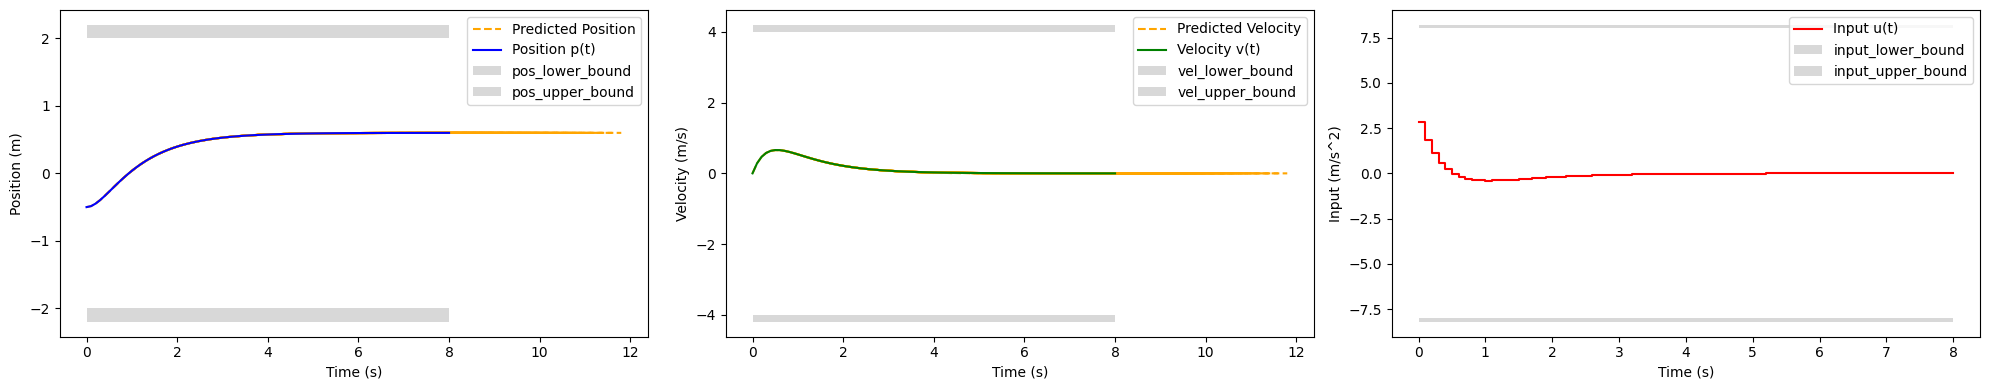

In [3]:
# Define the MPC controller
controller_mpc = MPCController(env, dynamics, Q, R, Qf, freq, N, name='MPC')

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc = Simulator(dynamics, controller_mpc, env, 1/freq, t_terminal)
simulator_mpc.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc = Visualizer(simulator_mpc)
visualizer_mpc.display_plots()

Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC.so
rm -f acados_solver_MPC.o
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o acados_solver_MPC.o acados_solver_MPC.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o MPC_model/MPC_expl_ode_fun.o MPC_model/MPC_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include 

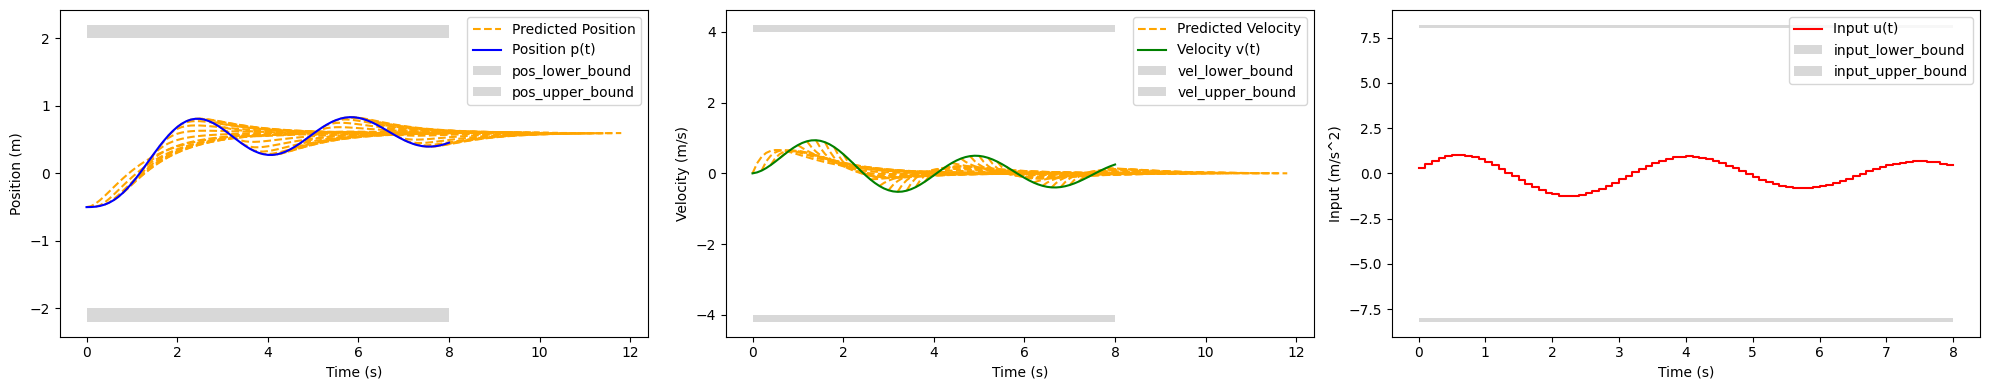

In [4]:
# Define the MPC controller
controller_mpc = MPCController(env, dynamics, Q, R, Qf, freq, N, name='MPC')

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc = Simulator(dynamics, controller_mpc, env, 1/freq, t_terminal, type='identified', param_id=np.array([1.0, 1.0]))
simulator_mpc.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc = Visualizer(simulator_mpc)
visualizer_mpc.display_plots()

In [ ]:
# Derived class for MPC Controller
class IdentifiedMPCController(LQRController):
    def __init__(
            self, 
            env: Env, 
            dynamics: Dynamics, 
            Q: np.ndarray, 
            R: np.ndarray, 
            Qf: np.ndarray, 
            freq: float, 
            N: int, 
            param_id: np.array = None,
            name: str = 'MPC', 
            type: str = 'MPC', 
            verbose: bool = True
        ) -> None:

        """
        Initialize the MPC Controller with Acados.

        Args:
        - env: The environment providing initial and target states.
        - dynamics: The system dynamics.
        - Q: State cost matrix.
        - R: Control cost matrix.
        - Qf: Terminal state cost matrix.
        - freq: Control frequency.
        - N: Prediction horizon.
        - verbose: Print debug information if True.
        """

        self.Qf = Qf
        # Prediction horizon
        self.N = N 
        # acc = 1 / (s * params[0] + params[1]) * acc_cmd
        self.params = param_id

        self.ocp = None
        self.solver = None
        
        # Initialize internal state variable for input
        self.current_input = 0

        super().__init__(env, dynamics, Q, R, freq, name, type, verbose)

    def setup(self) -> None:
        """
        Define the MPC optimization problem using Acados.
        """
        # Initialize Acados model
        model = AcadosModel()
        model.name = self.name
        
        # Define state variables and the constants
        p = ca.SX.sym("p")
        v = ca.SX.sym("v")
        u = ca.SX.sym("u")
        u_cmd = ca.SX.sym("u_cmd")
        Gravity = 9.81

        theta = self.env.theta(p)

        # Expression of dynamics
        dpdt = v
        dvdt = u * ca.cos(theta) - Gravity * ca.sin(theta) * ca.cos(theta)
        dudt = (1/self.params[0]) * u_cmd - (self.params[1]/self.params[0]) * u # input dynamics
        
        state = ca.vertcat(p, v, u)
        input = ca.vertcat(u_cmd)
        rhs = ca.vertcat(dpdt, dvdt, dudt)

        dim_states = state.numel()  
        dim_inputs = input.numel()
        
        f_expl_expr = ca.Function("dynamics_function", [state, input], [rhs])

        # Define model: dx/dt = f(x, u)
        model.x = state
        model.u = input
        model.f_expl_expr = ca.vertcat(f_expl_expr(state, input))
        model.f_impl_expr = None

        # Set up Acados OCP
        ocp = AcadosOcp()
        ocp.model = model
        ocp.dims.N = self.N  # Prediction horizon
        ocp.solver_options.tf = self.N * self.dt  # Total prediction time
        ocp.solver_options.qp_solver = "PARTIAL_CONDENSING_HPIPM"
        ocp.solver_options.integrator_type = "ERK"
        ocp.solver_options.nlp_solver_type = "SQP"

        # Set up other hyperparameters in SQP solving
        ocp.solver_options.nlp_solver_max_iter = 100
        ocp.solver_options.nlp_solver_tol_stat = 1E-6
        ocp.solver_options.nlp_solver_tol_eq = 1E-6
        ocp.solver_options.nlp_solver_tol_ineq = 1E-6
        ocp.solver_options.nlp_solver_tol_comp = 1E-6

        # Set up cost function
        ocp.cost.cost_type = "LINEAR_LS"
        ocp.cost.cost_type_e = "LINEAR_LS"
        ocp.cost.W = np.block([
            [self.Q, np.zeros((self.dim_states, self.dim_inputs)), np.zeros((self.dim_states, dim_inputs))],
            [np.zeros((self.dim_inputs, self.dim_states)), self.R, np.zeros((self.dim_inputs, dim_inputs))],
            [np.zeros((dim_inputs, dim_states+dim_inputs))],
        ])
        ocp.cost.W_e = np.block([
            [self.Qf, np.zeros((self.dim_states, self.dim_inputs))],
            [np.zeros((self.dim_inputs, self.dim_states+self.dim_inputs))],
        ])

        # Initialize reference of task (stabilization)
        ocp.cost.yref = np.zeros(dim_states + dim_inputs) 
        ocp.cost.yref_e = np.zeros(dim_states) 

        # Set up mapping from QP to OCP
        # Define output matrix for non-terminal state
        ocp.cost.Vx = np.block([
            [np.eye(dim_states)],
            [np.zeros((dim_inputs, dim_states))]
        ])
        # Define breakthrough matrix for non-terminal state
        ocp.cost.Vu = np.block([
            [np.zeros((dim_states, dim_inputs))],
            [np.eye(dim_inputs)]
        ])
        # Define output matrix for terminal state
        ocp.cost.Vx_e = np.eye(dim_states)

        # state constraint (old state + input)
        init_u = 0.0
        ocp.constraints.x0 = np.append(self.init_state, init_u)  # Initial state

        if self.env.state_lbs is None:
            state_lbs = np.full(self.dim_states, -1e6)
        else:
            state_lbs = self.env.state_lbs
        
        if self.env.state_ubs is None:
            state_ubs = np.full(self.dim_states, 1e6)
        else:
            state_ubs = self.env.state_ubs
        
        if self.env.input_lbs is None:
            input_lbs = np.full(self.dim_inputs, -1e6)
        else:
            input_lbs = self.env.input_lbs
        
        if self.env.input_ubs is None:
            input_ubs = np.full(self.dim_inputs, 1e6)
        else:
            input_ubs = self.env.input_ubs

        ocp.constraints.idxbx = np.arange(dim_states)
        ocp.constraints.idxbx_e = np.arange(dim_states)
        ocp.constraints.lbx_0 = np.append(state_lbs, input_lbs)
        ocp.constraints.ubx_0 = np.append(state_ubs, input_ubs)
        ocp.constraints.lbx = np.append(state_lbs, input_lbs)
        ocp.constraints.ubx = np.append(state_ubs, input_ubs)
        ocp.constraints.lbx_e = np.append(state_lbs, input_lbs)
        ocp.constraints.ubx_e = np.append(state_ubs, input_ubs)
        
        # input command constraint
        u_cmd_lb = -10.0
        u_cmd_ub = 10.0
        if self.env.input_lbs is None:
            input_lbs = np.full(dim_inputs, -1e6)
        else:
            input_lbs = u_cmd_lb
        
        if self.env.input_ubs is None:
            input_ubs = np.full(dim_inputs, 1e6)
        else:
            input_ubs = u_cmd_ub

        ocp.constraints.idxbu = np.arange(dim_inputs)
        ocp.constraints.lbu = np.array(self.env.input_lbs)
        ocp.constraints.ubu = np.array(self.env.input_ubs)

        # Set up Acados solver
        self.ocp = ocp
        self.solver = AcadosOcpSolver(ocp, json_file=f"{model.name}.json")

        if self.verbose:
            print("MPC setup with Acados completed.")

    @check_input_constraints
    def compute_action(self, current_state: np.ndarray, current_time) -> np.ndarray:
        """
        Solve the MPC problem and compute the optimal control action.

        Args:
        - current_state: The current state of the system.
        - current_time: The current time (not used in this time-invariant case).

        Returns:
        - Optimal control action.
        """

        # Update initial state in the solver
        self.solver.set(0, "lbx", np.append(current_state, self.current_input))
        self.solver.set(0, "ubx", np.append(current_state, self.current_input))

        # Update reference trajectory for all prediction steps
        for i in range(self.N):
            self.solver.set(i, "yref", np.concatenate((self.target_state, np.zeros(self.dim_inputs), np.zeros(self.dim_inputs))))
        self.solver.set(self.N, "yref", np.concatenate((self.target_state, np.zeros(self.dim_inputs)))) # set reference valur for y_N seperately (different shape)

        # Solve the MPC problem
        status = self.solver.solve()
        #if status != 0:
        #    raise ValueError(f"Acados solver failed with status {status}")

        # Extract the first control action
        u_optimal = self.solver.get(0, "u")

        # update internal state variable
        self.current_input = self.solver.get(1, "x")[-1]

        # Extract the predictions
        x_pred = np.zeros((self.N + 1, self.dim_states))
        u_pred = np.zeros((self.N, self.dim_inputs))
        for i in range(self.N + 1):
            x_pred[i, :] = self.solver.get(i, "x")[:self.dim_states]
            if i < self.N:
                u_pred[i, :] = self.solver.get(i+1, "x")[self.dim_states]

        if self.verbose:
            print(f"Optimal control action: {u_optimal}")
            print(f"x_pred: {x_pred}")
            print(f"u_pred: {u_pred}")

        return u_optimal, x_pred, u_pred

Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
rm -f libacados_ocp_solver_MPC_identified.so
rm -f acados_solver_MPC_identified.o
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o acados_solver_MPC_identified.o acados_solver_MPC_identified.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include -I/home/haocheng/acados/include/acados -I/home/haocheng/acados/include/blasfeo/include -I/home/haocheng/acados/include/hpipm/include  -c -o MPC_identified_model/MPC_identified_expl_ode_fun.o MPC_identified_model/MPC_identified_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/haocheng/acados/include

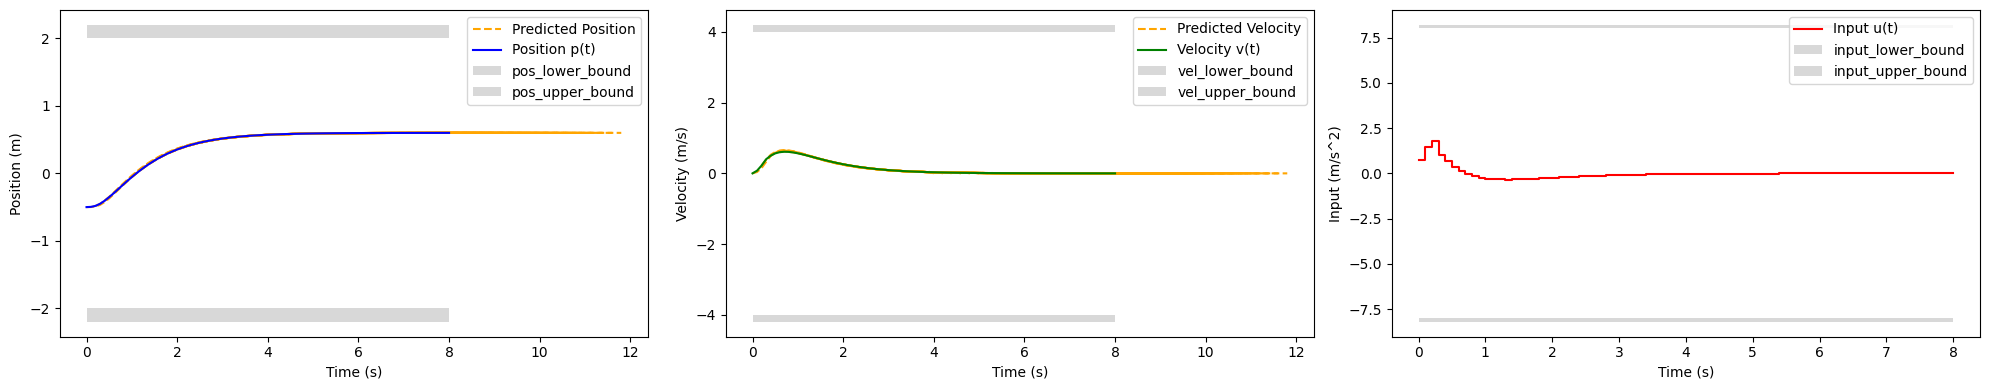

In [6]:
# Define the MPC controller
controller_mpc_identified = IdentifiedMPCController(env, dynamics, Q, R, Qf, freq, N, param_id=np.array([1.0, 1.0]), name='MPC_identified')

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc_identified = Simulator(dynamics, controller_mpc_identified, env, 1/freq, t_terminal, type='identified', param_id=np.array([1.0, 1.0]))
simulator_mpc_identified.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc_identified = Visualizer(simulator_mpc_identified)
visualizer_mpc_identified.display_plots()